I came across a paper studying the RNA 'velocity' in single cells (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6130801/). I thought that this was one of the most incredible things Ive seen in awhile, and since I've done some transcriptome and genome assemblies myself, decided that I should download some single cell RNA datatsets and look into what steps go into a single cell analysis. I started by reading this paper:https://www.embopress.org/doi/10.15252/msb.20188746 in order to get an idea of how this data gets processed. Next, I downloaded a dataset from 10X's website to analyze myself. The link to the fastq files I downloaded can be found here: https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.1.0/connect_5k_pbmc_NGSC3_ch1?

In [2]:
cd E:/Single_Cell_RNA/

E:\Single_Cell_RNA


Ive started by just untaring the files that came with the 10X download.

In [7]:
ls

 Volume in drive E is Seagate
 Volume Serial Number is B078-DDB7

 Directory of E:\Single_Cell_RNA

04/12/2020  06:34 PM    <DIR>          .
04/12/2020  06:34 PM    <DIR>          ..
02/25/2020  03:47 PM    <DIR>          connect_5k_pbmc_NGSC3_ch1_fastqs
04/12/2020  06:19 PM    21,449,758,720 connect_5k_pbmc_NGSC3_ch1_fastqs.tar
               1 File(s) 21,449,758,720 bytes
               3 Dir(s)  710,490,517,504 bytes free


In [10]:
cd connect_5k_pbmc_NGSC3_ch1_fastqs/

E:\Single_Cell_RNA\connect_5k_pbmc_NGSC3_ch1_fastqs


In [11]:
ls

 Volume in drive E is Seagate
 Volume Serial Number is B078-DDB7

 Directory of E:\Single_Cell_RNA\connect_5k_pbmc_NGSC3_ch1_fastqs

02/25/2020  03:47 PM    <DIR>          .
02/25/2020  03:47 PM    <DIR>          ..
02/25/2020  03:36 PM    <DIR>          connect_5k_pbmc_NGSC3_ch1_gex_1
02/25/2020  03:47 PM    <DIR>          connect_5k_pbmc_NGSC3_ch1_gex_2
               0 File(s)              0 bytes
               4 Dir(s)  710,490,517,504 bytes free


Looks like there are two directories of files

In [12]:
cd connect_5k_pbmc_NGSC3_ch1_gex_1/

E:\Single_Cell_RNA\connect_5k_pbmc_NGSC3_ch1_fastqs\connect_5k_pbmc_NGSC3_ch1_gex_1


In [13]:
ls

 Volume in drive E is Seagate
 Volume Serial Number is B078-DDB7

 Directory of E:\Single_Cell_RNA\connect_5k_pbmc_NGSC3_ch1_fastqs\connect_5k_pbmc_NGSC3_ch1_gex_1

02/25/2020  03:36 PM    <DIR>          .
02/25/2020  03:36 PM    <DIR>          ..
02/25/2020  03:36 PM       460,864,019 connect_5k_pbmc_NGSC3_ch1_gex_1_S1_L001_I1_001.fastq.gz
02/25/2020  03:36 PM     1,477,762,877 connect_5k_pbmc_NGSC3_ch1_gex_1_S1_L001_R1_001.fastq.gz
02/25/2020  03:36 PM     3,460,384,956 connect_5k_pbmc_NGSC3_ch1_gex_1_S1_L001_R2_001.fastq.gz
02/25/2020  03:36 PM       459,327,363 connect_5k_pbmc_NGSC3_ch1_gex_1_S1_L002_I1_001.fastq.gz
02/25/2020  03:36 PM     1,479,659,920 connect_5k_pbmc_NGSC3_ch1_gex_1_S1_L002_R1_001.fastq.gz
02/25/2020  03:36 PM     3,466,383,782 connect_5k_pbmc_NGSC3_ch1_gex_1_S1_L002_R2_001.fastq.gz
               6 File(s) 10,804,382,917 bytes
               2 Dir(s)  710,490,517,504 bytes free


Alright, so it looks like both directories contain two sets of paired end reads with their index reads as well. There appears to be one sample run on two different sequencing lanes. Going to take a closer look into what the reads look like.
It appears that read 1 is 28bp long containing the 16bp Chromium barcode and 12bp UMI, while read 2 is 91 bp long, seemingly containing actual transcript sequence. I'd like to take a closer of a look into the chromium barcodes and the UMI's to see what they look like, but first, 10X claims there are in total 279,853,700 reads, so lets check to see if our numbers match up. Im unsure if you would need to concatenate all the files in the two directories to get to this number, but that makes sense to me so Ill test it below:

In [8]:
from collections import Counter
import os

total_length = 0
for root, dirs, files in os.walk('E:Single_Cell_RNA/'):
    for file in files:
        if 'R2' in file.split('_'):
            filepath = os.path.join(root, file)
            with open(filepath, 'r') as f:
                for line in f:
                    total_length += 1
print(total_length/4)
    
   

279853700.0


Looks like our numbers match up with what is expected! Off to a good start, lets take a closer look at those chromium barcodes and UMIs now. we will try to make the common number of barcodes vs umis plot that I have seen all over 10X's website. Since this will be pretty computationally heavy, lets only make them for the first file that we encounter, if everything looks good, ill assume it will also go well for the other files.

In [2]:
from collections import defaultdict
import os

per_barcode_umis = defaultdict(int) # a dicionary where the keys are barcodes and the values are the counts of unique umis per barcode
umis_seen = defaultdict(list) # need to store a dictionary of umi's that have been seen by each barcode. 
for root, dirs, files in os.walk('E:Single_Cell_RNA/connect_5k_pbmc_NGSC3_ch1_fastqs/'):
    for file in files:
        if 'R1' in file.split('_'):
            filepath = os.path.join(root, file)
            with open(filepath, 'r') as f:
                for i, line in enumerate(f):
                        if i % 4 == 1:
                            chromium_barcode = line[:12]
                            umi = line[12:].strip()
                            try:  
                                if umi in umis_seen[chromium_barcode]: #I'm not going to count a umi if it is a duplicate for a barcode
                                    pass
                                else:
                                    per_barcode_umis[chromium_barcode] += 1
                                    umis_seen[chromium_barcode].append(umi)
                            except:
                                pass
                break
                

Now we have a dictionary of barcodes and the counts of umis per barcode, as well as each umi that goes with each barcode. Looking at 10X's website, in order to make this graph: 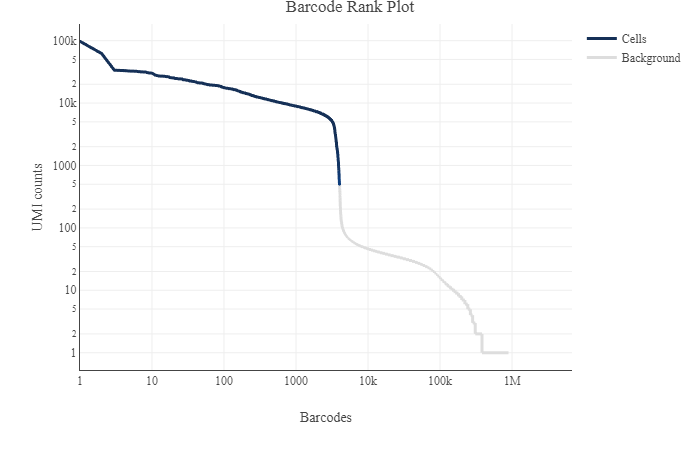
"The y-axis is the number of UMI counts mapped to each barcode and the x-axis is the number of barcodes below that value.A steep drop-off is indicative of good separation between the cell-associated barcodes and the barcodes associated with empty partitions." From the data that I collected, the only thing I would need to do is sort the counts I collected, and then plot them based on length of the list at any given point. I should note that this was the graph for the whole data set that I downloaded, and Im only doing it based on one of the files that I downloaded due to the computational demands that will be necessary to store all of the information.

In [52]:
import matplotlib.pyplot as plt

vals = [value for value in per_barcode_umis.values()] # get all the umi counts for each barcode
sort_vals = sorted(vals, reverse=True) # sort them from highest to lowest
number_left_over = []

for i in sort_vals:
    number_left_over.append(len([t for t in sort_vals if t >= i]))#This code may seem odd, but I am going through the sorted values (which are the number of umis per barcode) and then counting up how many values are greater than the current value I am on.
    

Text(0, 0.5, 'UMI counts')

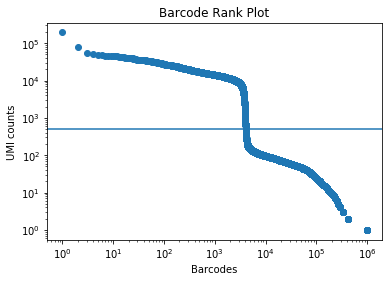

In [60]:
plt.scatter(number_left_over, sort_vals)
plt.yscale('log')
plt.xscale('log')
plt.axhline(y=500)
plt.title('Barcode Rank Plot')
plt.xlabel('Barcodes')
plt.ylabel('UMI counts')

Perfect! We see pretty much the exact same distributuion that they do, which is pretty cool given that it was from only one of the files. They seem to draw the line at ~500 UMIs for choosing whether or not a particular barcode is actually an individual cell or whether it seems to be a background droplet. I included an abline on my graph to show that point as well. Overall, I would not suggest doing this the way I did. It was computationally expensive (took ~20Gb of ram and ~12 hours of CPU time actually doing the calculations). Instead, I would just run cellranger counts in order to get this information, but since this is my first time looking into single cell data, I determined it would be worth it to actaully look at the data for myself.  

In order to get the expression/gene matrix data, I am going to run cellranger count (my full command was: ~/cellranger/cellranger-3.1.0/cellranger count --id=gex_1 --expect-cells=5000 --fastqs=/mnt/e/Single_Cell_RNA/connect_5k_pbmc_NGSC3_ch1_fastqs/connect_5k_pbmc_NGSC3_ch1_gex_1 --transcriptome=cellranger_refs/refdata-cellranger-GRCh38-3.0.0      -Ran from /mnt/e/Single_Cell_RNA/).  I didn't run it with any extra options initially, I plan to see what results the default parameters give me and then see how much this differs from 10X's analysis of the dataset. 

Now that I've run cellranger, it looks like I have all the inputs neccessary in order to run velocyto. Lucklily for me there is a run10X command that looks like it will make it easy to generate the loom file that will then be used in order to actually do the RNA velocity analysis (My full command was: velocyto run10x ./gex_1/ cellranger_refs/refdata-cellranger-GRCh38-3.0.0/genes/genes.gtf). After this step, it looks like the rest of the analysis will be completed using python, so I'll start the new analysis using a new Jupyter Notebook